# Disaster Classification via tweets

Target:

1 = Disaster

0 = Not Disaster

In [2]:
# Check gpu
!nvidia-smi -L

GPU 0: Tesla K80 (UUID: GPU-d1bae8d5-1022-fed4-fd3b-bfe3efcdcdab)


## Visualizing a text dataset

In [4]:
import pandas as pd
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [5]:
# Shuffle our training data
train_df_shuffled = train_df.sample(frac=1, random_state=42)
train_df_shuffled.head()

,id,keyword,location,text,target
2644,3796,destruction,NaN,So you have a new weapon that can cause un-ima...,1
2227,3185,deluge,NaN,The f$&amp;@ing things I do for #GISHWHES Just...,0
5448,7769,police,UK,DT @georgegalloway: RT @Galloway4Mayor: ÛÏThe...,1
132,191,aftershock,NaN,Aftershock back to school kick off was great. ...,0
6845,9810,trauma,"Montgomery County, MD",in response to trauma Children of Addicts deve...,0


In [6]:
# What does the test dataframe looks like
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [7]:
# How many examples of each class in train set
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

In [8]:
# How many total samples?
len(train_df), len(test_df)

(7613, 3263)

In [9]:
# Let's visualize random training examples
import random
random_index = random.randint(0, len(train_df)-5)
for row in train_df_shuffled[["text","target"]][random_index:random_index+5].itertuples():
  _,text,target = row
  print(f"Target : {target} - ", "Real Disaster" if target > 0 else "Not Real Disaster")
  print(f"Text : \n {text} \n")
  print("---\n")

Target : 1 -  Real Disaster
Text : 
 Tarp is protecting outfield and cannot be moved. Infield getting deluged. 

---

Target : 0 -  Not Real Disaster
Text : 
 6 Trends Are Driving a Data Tsunami for Startups http://t.co/sjh0HsRp4s #startup 

---

Target : 0 -  Not Real Disaster
Text : 
 @mattcohen4fake Gamma Ray January Worlds Collide She Waits Be Me Wave Past Perfect Reunion Lucky Cool If I Come Over Hot Times... 

---

Target : 1 -  Real Disaster
Text : 
 @POTUS Thx for emergency dec. http://t.co/DyWWNbbYvJ 4 days and no plan to get H20 to those who have no transport. Can you deploy troops? 

---

Target : 0 -  Not Real Disaster
Text : 
 investigate why Robert mueller didn't respond to my complaints since Nov 2011 &amp; just left me/son out her in danger http://t.co/pe2D3HCsNI 

---



In [10]:
# Getting our data in separate lists for sentences and labels
train_sentences = train_df_shuffled['text'].to_numpy()
train_labels =  train_df_shuffled['target'].to_numpy() 

In [11]:
# Check the first 10 samples
train_sentences[:10], train_labels[:10]

(array(['So you have a new weapon that can cause un-imaginable destruction.',
        'The f$&amp;@ing things I do for #GISHWHES Just got soaked in a deluge going for pads and tampons. Thx @mishacollins @/@',
        'DT @georgegalloway: RT @Galloway4Mayor: \x89ÛÏThe CoL police can catch a pickpocket in Liverpool Stree... http://t.co/vXIn1gOq4Q',
        'Aftershock back to school kick off was great. I want to thank everyone for making it possible. What a great night.',
        'in response to trauma Children of Addicts develop a defensive self - one that decreases vulnerability. (3',
        '@Calum5SOS you look like you got caught in a rainstorm this is amazing and disgusting at the same time',
        'my favorite lady came to our volunteer meeting\nhopefully joining her youth collision and i am excite http://t.co/Ij0wQ490cS',
        '@brianroemmele UX fail of EMV - people want to insert and remove quickly like a gas pump stripe reader. 1 person told me it crashed the POS',
       

Create a tensorboard callback function to plot our loss curves 

In [12]:
import datetime

def create_tensorboard_callback(dir_name, experiment_name):
  """
  Creates a TensorBoard callback instand to store log files.
  Stores log files with the filepath:
    "dir_name/experiment_name/current_datetime/"
  Args:
    dir_name: target directory to store TensorBoard log files
    experiment_name: name of experiment directory (e.g. efficientnet_model_1)
  """
  log_dir = dir_name + "/" + experiment_name + "/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
  tensorboard_callback = tf.keras.callbacks.TensorBoard(
      log_dir=log_dir
  )
  print(f"Saving TensorBoard log files to: {log_dir}")
  return tensorboard_callback

## Create a model to train upon

### TensorFlow Hub Pretrained Sentence Encoder

In [14]:
# Create a keras layers using the USE pretrained layer from a tensorflow hub
import tensorflow as tf
import tensorflow_hub as hub
sentence_encoder_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=True,
                                        name="USE")

In [15]:
# Create a model using the Sequential API
from tensorflow.keras import layers

model = tf.keras.Sequential([
  sentence_encoder_layer,
  layers.Dense(1, activation="sigmoid", name="output_layer")
])

# Compile model
model.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

In [16]:
# Get summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
USE (KerasLayer)             (None, 512)               256797824 
_________________________________________________________________
output_layer (Dense)         (None, 1)                 513       
Total params: 256,798,337
Trainable params: 256,798,337
Non-trainable params: 0
_________________________________________________________________


In [17]:
# Make validation data for training the model
from sklearn.model_selection import train_test_split
training_sentences, validation_sentences, training_labels, validation_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                                                train_df_shuffled["target"].to_numpy(),
                                                                                                test_size=0.1, # 10% of training data for validation
                                                                                                random_state=42)
len(training_sentences), len(validation_sentences), len(training_labels), len(validation_labels)

(6851, 762, 6851, 762)

In [18]:
# Fit the data to our model
history_model = model.fit(train_sentences,
                          train_labels,
                          epochs=5,
                          validation_data=(validation_sentences,validation_labels),
                          callbacks=[create_tensorboard_callback("model_logs","tf_hub_sentence_encoder")])

Saving TensorBoard log files to: model_logs/tf_hub_sentence_encoder/20211023-230944
Epoch 1/5
238/238 [==============================] - 66s 238ms/step - loss: 0.4636 - accuracy: 0.7925 - val_loss: 0.3028 - val_accuracy: 0.9081
Epoch 2/5
238/238 [==============================] - 55s 233ms/step - loss: 0.2432 - accuracy: 0.9095 - val_loss: 0.1109 - val_accuracy: 0.9711
Epoch 3/5
238/238 [==============================] - 55s 233ms/step - loss: 0.0861 - accuracy: 0.9756 - val_loss: 0.0409 - val_accuracy: 0.9856
Epoch 4/5
238/238 [==============================] - 55s 232ms/step - loss: 0.0483 - accuracy: 0.9844 - val_loss: 0.0375 - val_accuracy: 0.9882
Epoch 5/5
238/238 [==============================] - 55s 233ms/step - loss: 0.0331 - accuracy: 0.9892 - val_loss: 0.0178 - val_accuracy: 0.9961


In [21]:
# Plot loss curves
import matplotlib.pyplot as plt

def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  Args:
    history: TensorFlow model History object (see: https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/History)
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

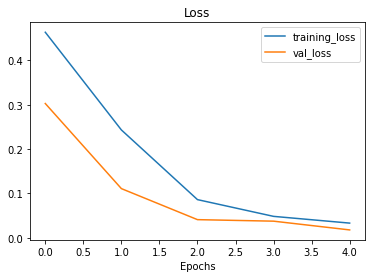

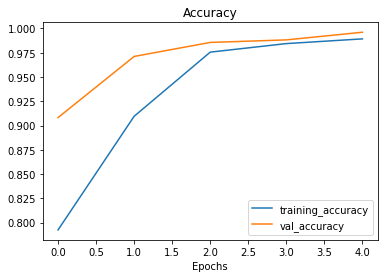

In [22]:
plot_loss_curves(history_model)

In [24]:
# Create a list of sentences for test dataset
test_sentences = test_df["text"].to_numpy()
test_sentences[:10]

array(['Just happened a terrible car crash',
       'Heard about #earthquake is different cities, stay safe everyone.',
       'there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all',
       'Apocalypse lighting. #Spokane #wildfires',
       'Typhoon Soudelor kills 28 in China and Taiwan',
       "We're shaking...It's an earthquake",
       "They'd probably still show more life than Arsenal did yesterday, eh? EH?",
       'Hey! How are you?', 'What a nice hat?', 'Fuck off!'], dtype=object)

In [25]:
# Make predictions on the test dataset
model_pred_probs = model.predict(test_sentences)

In [27]:
# Check first 10
model_pred_probs[:10], model_pred_probs.shape

(array([[0.9799708 ],
        [0.9944344 ],
        [0.99547833],
        [0.99480325],
        [0.99607533],
        [0.9899484 ],
        [0.0036551 ],
        [0.00381143],
        [0.0036211 ],
        [0.00351992]], dtype=float32), (3263, 1))

In [28]:
# Change the prediciton probabilities to label format
model_preds = tf.squeeze(tf.round(model_pred_probs))
model_preds[:10],model_preds.shape

(<tf.Tensor: shape=(10,), dtype=float32, numpy=array([1., 1., 1., 1., 1., 1., 0., 0., 0., 0.], dtype=float32)>,
 TensorShape([3263]))

In [38]:
# Let's visualize our predictions
import pandas as pd
results_df = pd.DataFrame({"Tweets":test_sentences,
                          "Predicted Label":model_preds,
                          "Predicted Probability":tf.squeeze(model_pred_probs)})
results_df.head(20)

,Tweets,Predicted Label,Predicted Probability
0,Just happened a terrible car crash,1.0,0.979971
1,"Heard about #earthquake is different cities, s...",1.0,0.994434
2,"there is a forest fire at spot pond, geese are...",1.0,0.995478
3,Apocalypse lighting. #Spokane #wildfires,1.0,0.994803
4,Typhoon Soudelor kills 28 in China and Taiwan,1.0,0.996075
5,We're shaking...It's an earthquake,1.0,0.989948
6,They'd probably still show more life than Arse...,0.0,0.003655
7,Hey! How are you?,0.0,0.003811
8,What a nice hat?,0.0,0.003621
9,Fuck off!,0.0,0.003520


In [39]:
# Visualize random samples
for row in results_df[:10].itertuples():
  _,text,pred,pred_prob = row
  print(f"Pred : {pred}, Prob : {pred_prob}")
  print(f"Text : \n {text}\n")
  print("-----\n")

Pred : 1.0, Prob : 0.9799708127975464
Text : 
 Just happened a terrible car crash

-----

Pred : 1.0, Prob : 0.9944344162940979
Text : 
 Heard about #earthquake is different cities, stay safe everyone.

-----

Pred : 1.0, Prob : 0.9954783320426941
Text : 
 there is a forest fire at spot pond, geese are fleeing across the street, I cannot save them all

-----

Pred : 1.0, Prob : 0.994803249835968
Text : 
 Apocalypse lighting. #Spokane #wildfires

-----

Pred : 1.0, Prob : 0.9960753321647644
Text : 
 Typhoon Soudelor kills 28 in China and Taiwan

-----

Pred : 1.0, Prob : 0.9899483919143677
Text : 
 We're shaking...It's an earthquake

-----

Pred : 0.0, Prob : 0.003655102802440524
Text : 
 They'd probably still show more life than Arsenal did yesterday, eh? EH?

-----

Pred : 0.0, Prob : 0.0038114278577268124
Text : 
 Hey! How are you?

-----

Pred : 0.0, Prob : 0.003621102310717106
Text : 
 What a nice hat?

-----

Pred : 0.0, Prob : 0.0035199164412915707
Text : 
 Fuck off!

-----



In [40]:
# Save the model
model.save("tf_hub_use_model")

INFO:tensorflow:Assets written to: tf_hub_use_model/assets


INFO:tensorflow:Assets written to: tf_hub_use_model/assets


## Finding the most wrong predictions

In [41]:
# Make predictions on validation set
validation_pred_probs = model.predict(validation_sentences)
validation_preds = tf.squeeze(tf.round(validation_pred_probs))

In [42]:
# Create a dataframe with val sentences, val labels and best performing model prediction labels and probabilities
val_df = pd.DataFrame({"text":validation_sentences,
                       "target":validation_labels,
                       "pred":validation_preds,
                       "pred_prob":tf.squeeze(validation_pred_probs)})

val_df.head()

,text,target,pred,pred_prob
0,DFR EP016 Monthly Meltdown - On Dnbheaven 2015...,0,0.0,0.003614
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.614669
2,Gunmen kill four in El Salvador bus attack: Su...,1,1.0,0.996479
3,@camilacabello97 Internally and externally scr...,1,1.0,0.993419
4,Radiation emergency #preparedness starts with ...,1,1.0,0.996018


In [43]:
# Find the wrong predictions and sort by prediction probabilities
most_wrong = val_df[val_df["target"] != val_df["pred"]].sort_values("pred_prob",ascending=False)
most_wrong[:5]

,text,target,pred,pred_prob
1,FedEx no longer to transport bioterror germs i...,0,1.0,0.614669
402,Earthquake drill ??,1,0.0,0.149481
706,How is it one careless match can start a fores...,1,0.0,0.013972


In [45]:
# Check out full tweets of our most wrong predictions
for row in most_wrong.itertuples():
  _,text,target,pred,pred_prob = row
  print(f"Target : {target}, Pred : {pred}, Prob : {pred_prob}")
  print(f"Text : \n {text}\n")
  print("-----\n")

Target : 0, Pred : 1.0, Prob : 0.6146690845489502
Text : 
 FedEx no longer to transport bioterror germs in wake of anthrax lab mishaps http://t.co/qZQc8WWwcN via @usatoday

-----

Target : 1, Pred : 0.0, Prob : 0.14948110282421112
Text : 
 Earthquake drill ??

-----

Target : 1, Pred : 0.0, Prob : 0.013971691019833088
Text : 
 How is it one careless match can start a forest fire but it takes a whole box to start a campfire?

-----



## Save the results prediction file on test dataset

In [46]:
results_df.to_csv("results.csv")